In [2]:
import platform
if platform.system() == 'Linux':
    path0 = '/content/drive/My Drive/Colab Notebooks/MFTI/test/mipt_test_git'
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.insert(1, path0)
else:
    path0 = '/MFTI/test/mipt_test_git'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# sys.path.append(os.path.abspath(path0))
# sys.path.append('../')

sys.path

['',
 '/content/drive/My Drive/Colab Notebooks/MFTI/test/mipt_test_git',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [10]:
from lib import *
import lib

# lib.utils

In [15]:
metrics.dice

<function lib.metrics.dice>

In [16]:
import os
# os.chdir("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob
    
from lib import *

%matplotlib inline

# Задача

**Требуется:** предложить модель, сегментирующую человека на фотографии.  
  
**Вход:** фотография 320x240x3.  
**Выход:** маска человека 320x240.  
**Метрика:** [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).  
  
  
Данные представляют из себя набор фотографий человека и маски, определяющей положение человека на фотографии.  
Доступные данные разделены на несколько папок:  
- `train` содержит фотографии 320x240x3;
- `train_mask` содержит маски для фотографий из `train` 320x240;
- `valid` содержит фотографии 320x240x3;
- `valid_mask` содержит маски для фотографий из `valid` 320x240;
- `test` содержит фотографии 320x240x3.  
  
Для лучшей модели требуется создать 2 файла, которые необходимы для валидации Вашего решения:
- сохраненные маски для картинок из valid в формате pred_valid_template.csv (в архиве с `data`);
- html страницу с предсказанием модели для всех картинок из test и папку с используемыми картинками в этой html странице для её просмотра.

Также необходимо:
- подготовить код для проверки (докстринги, PEP8);
- создать отчет (в jupyter ноутбуке) с описанием Вашего исследования, предобработки, постобработки, проверямых гипотез, используемых моделей, описание лучшего подхода и т.п.

Примеры приведены ниже.

---

# Данные, метрики и доступные функции

Посмотрим на данные:

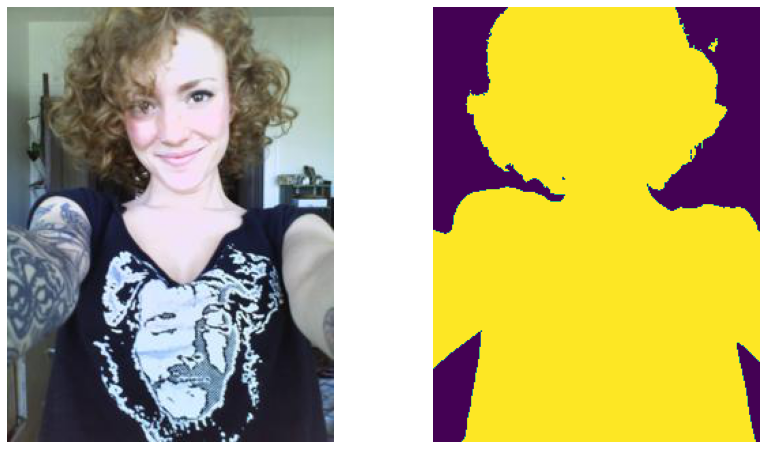

In [28]:
path = path0 + "/data/train"
images = os.listdir(path)
ind = np.random.choice(images).split(".")[0]

img = np.array(Image.open(f"{path}/{ind}.jpg"))
mask = np.array(Image.open(f"{path}_mask/{ind}.png"))
show_img_with_mask(img, mask)

Пример подсчета метрики:

In [21]:
random_mask = np.random.randint(low=0, high=2, size=mask.shape)
get_dice(mask, random_mask)

0.3448193347690829

Можно для последовательности масок вычислить среднее значение метрики:

In [22]:
random_masks_1 = [np.random.randint(low=0, high=2, size=mask.shape) for i in range(10)]
random_masks_2 = [np.random.randint(low=0, high=2, size=mask.shape) for i in range(10)]
get_dice(random_masks_1, random_masks_2)

0.4989989511844263

Пример использования функций `encode_rle` и `decode_rle`:
1. Функция `encode_rle` используется для кодирования маски в строку для последующей записи в файл;
2. Функция `decode_rle` используется для восстановления маски по закодированной строке.

In [23]:
rle_mask = encode_rle(mask)
rle_mask

'35852 6 36086 22 36322 29 36559 34 36797 38 37035 41 37273 44 37512 46 37750 49 37989 52 38228 54 38467 56 38706 57 38945 59 39184 61 39423 63 39662 65 39902 65 40141 67 40381 67 40620 69 40860 70 41099 71 41339 72 41579 72 41818 74 42058 74 42298 75 42537 77 42777 77 43016 78 43256 78 43496 79 43736 79 43975 80 44215 80 44455 80 44695 80 44935 81 45175 81 45415 81 45655 81 45895 81 46134 82 46374 82 46614 82 46854 82 47094 82 47334 82 47574 82 47815 81 48055 81 48295 81 48535 80 48775 80 49015 82 49255 83 49495 83 49735 83 49975 83 50214 84 50453 84 50692 85 50932 85 51173 84 51413 84 51653 84 51893 84 52133 84 52373 84 52613 84 52853 84 53094 83 53334 82 53574 82 53814 82 53951 7 54054 81 54190 9 54295 80 54430 9 54535 80 54669 10 54775 80 54909 10 55015 79 55148 11 55256 78 55388 11 55497 77 55628 11 55737 77 55868 12 55979 75 56107 13 56222 72 56347 13 56462 72 56587 13 56703 70 56827 13 56943 70 57067 13 57183 70 57307 13 57423 70 57547 13 57663 70 57787 14 57904 69 58027 14 5814

Теперь восстановим маску:

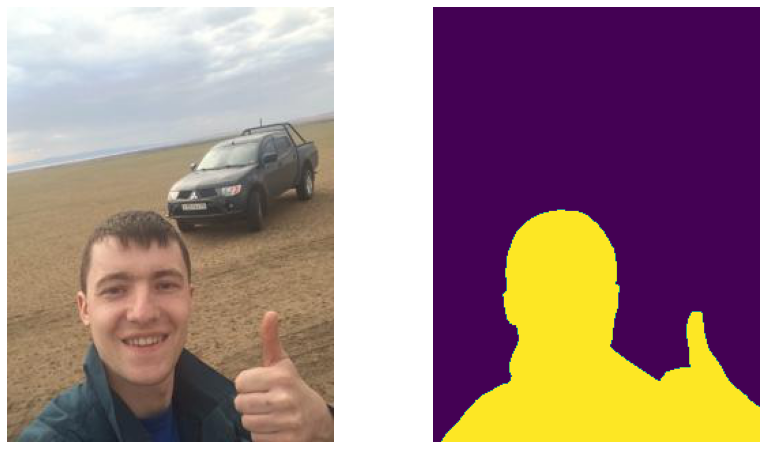

In [24]:
decoded_mask = decode_rle(rle_mask)
show_img_with_mask(img, decoded_mask)

---

# Результаты

Пример файла для изображений из `data/valid`:  
_Каждую предсказанную маску для изображения из `valid` необходимо закодировать и записать в показанный ниже файл, который служит примером, именно в таком виде нужно будет представить результат Вашего лучшего решения на данных из `valid`._

In [26]:
pred = pd.read_csv(path0 + "/data/pred_valid_template.csv")
pred.head()

,id,rle_mask
0,1315,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
1,1316,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
2,1317,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
3,1318,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
4,1319,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...


Для данных из `test` требуется создать html страницу + картинки для нее.  
Это можно сделать с помощью функции `get_html`, как показано ниже.

In [32]:
paths_to_imgs = sorted(glob(path0 + "/data/valid/*"))
pred_masks = [np.array(Image.open(path)) for path in sorted(glob(path0+"/data/valid_mask/*"))]

_ = get_html(paths_to_imgs, pred_masks, path_to_save=path0+"/results/example")

In [31]:
# get_html(paths_to_imgs, pred_masks, path_to_save=path0+"/results/example")

В папке `results` создался файл `example.html` и папка `examples` с используемыми картинками.